# Ensemble Learning through Bagging 

**bagging == Bootstrapping Aggregation** 

$\implies$  hyperparam = {M = #learners, alpha = # relative trainset size}


In [1]:
#!git clone https://github.com/tlpss/ML-Project2.git

import numpy as np
import random
import matplotlib.pyplot as plt
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.gaussian_process.kernels import RBF, WhiteKernel

# add project root folder to path to allow import local modules
import os
import sys
#sys.path.append(os.path.abspath(os.path.join('./ML-Project2')))

module_path = os.path.abspath(os.path.join('..'))
if module_path not in sys.path:
    sys.path.append(module_path)
# import local modules
from stochastic_models import *
from visualisations import *
from basic_estimator_model import *

## Parameter Configuration

In [2]:
np.random.seed(2020)

In [3]:
N_train = 5000
N_test = 50000
d = 1
T = 2

In [4]:
lambda_range = (N_train*1e-9 , N_train*1e-3)
alpha_range = (8.3*1e-5, 0.83)
length_scale = np.sort(1/np.sqrt((2*alpha_range[0], 2*alpha_range[1])))

## Create Kernel & prepare datasets

In [5]:
#kernel
kernel = RBF(length_scale= (length_scale[0] + length_scale[1])/2, length_scale_bounds=length_scale) \
        + WhiteKernel(noise_level= (lambda_range[0] + lambda_range[1])/2 , noise_level_bounds=lambda_range)


In [6]:
#generate drivers
s_train = MaxCallStochasticModel(N_train,d,[1/12,11/12])
s_train.generate_samples()
s_test = MaxCallStochasticModel(N_test, d, [1/12,11/12])
s_test.generate_samples()

In [7]:
#prepare datasets & values
y_train = s_train.y
X_train = s_train.X
S_train = s_train.S

y_test = s_test.y
X_test = s_test.X
S_test = s_test.S

V_T = y_test  
V_0 = s_test.generate_true_V(0)

V_0= V_0.mean()
V_0 # Average expected PROFIT!

0.07935344411249907

In [8]:
X_test.shape

(50000, 1, 2)

## Create Custom Models
(to have more control of splitting etc)

In [9]:
from aggregating.models import SimpleBagger
s = SimpleBagger(11,0.5,None)
s.get_params()

{'M': 11, 'predictor': None, 'train_size_alpha': 0.5}

## GridSearch

nB: cannot use Scikit gridsearch as it performs CV and we want to have a different test set of a larger size!

In [10]:
from multiprocessing import  cpu_count,current_process
from multiprocessing.pool import ThreadPool
import functools
import threading

from aggregating.gridsearch import create_logger, evaluate_model
from aggregating.utils import flatten_X

# GRIDSEARCH PARAMS
model = SimpleBagger(0,0,GaussianProcessRegressor(kernel,copy_X_train=False))
trials = 3
M_grid = [1,2,3,4,5,6,7,8]
alpha_grid = [0.5,0.7,0.9,1.0]
results = []
print(cpu_count())
### ACTUAL GRIDSEARCH
pool = ThreadPool(2) #avoid allocation issues
for m in M_grid:
    for alpha in alpha_grid:
        hyperparams= {'M':m, 'train_size_alpha':alpha}
        pool.apply_async(evaluate_model, args=(model,hyperparams,flatten_X(X_train),y_train,1, [1/12,11/12],trials,N_test,MaxCallStochasticModel),callback = create_logger(hyperparams,results))
pool.close()
pool.join()



2
 {'M': 1, 'train_size_alpha': 0.5} -> thread id = 140196775278336
fit
(5000, 2)
 {'M': 1, 'train_size_alpha': 0.7} -> thread id = 140196766885632
fit
(5000, 2)
predict
(50000, 2)
{'M': 1, 'train_size_alpha': 0.5} , 0 -> 0.18262429637849759
predict
(50000, 2)
predict
(50000, 2)
{'M': 1, 'train_size_alpha': 0.5} , 1 -> 0.17654918277401788
predict
(50000, 2)
{'M': 1, 'train_size_alpha': 0.5} , 2 -> 0.21779899681940598
{'M': 1, 'train_size_alpha': 0.5} -> [0.18262429637849759, 0.17654918277401788, 0.21779899681940598]
 {'M': 1, 'train_size_alpha': 0.9} -> thread id = 140196775278336logger {'M': 1, 'train_size_alpha': 0.5}, -> [0.18262429637849759, 0.17654918277401788, 0.21779899681940598]

fit
(5000, 2)
{'M': 1, 'train_size_alpha': 0.7} , 0 -> 0.2051590295879866
predict
(50000, 2)
{'M': 1, 'train_size_alpha': 0.7} , 1 -> 0.21792672729451226
predict
(50000, 2)
predict
(50000, 2)
{'M': 1, 'train_size_alpha': 0.7} , 2 -> 0.19736078187832648
{'M': 1, 'train_size_alpha': 0.7} -> [0.2051590295

In [11]:
converted_results = np.ones((len(M_grid),len(alpha_grid),trials))*(-1)
for item in results:
    print(item)
    converted_results[M_grid.index(item[0]),alpha_grid.index(item[1])] = item[2]

print(converted_results.shape)
print(converted_results)

[1, 0.5, [0.18262429637849759, 0.17654918277401788, 0.21779899681940598]]
[1, 0.7, [0.2051590295879866, 0.21792672729451226, 0.19736078187832648]]
[1, 0.9, [0.17051719923127792, 0.17311335210154008, 0.14202654165824224]]
[1, 1.0, [0.21291027450735855, 0.20884879694025454, 0.14261150795153682]]
[2, 0.5, [0.17610820972870736, 0.23235347058632386, 0.18824799999199276]]
[2, 0.7, [0.23603362883502615, 0.2075457146452947, 0.19968213865785034]]
[2, 0.9, [0.21685481641922036, 0.2072638895353321, 0.1922168801579054]]
[2, 1.0, [0.3275546516947335, 0.22934460432508874, 0.22006403256883011]]
[3, 0.5, [0.22830198017909856, 0.2386692808735103, 0.2780149180847711]]
[3, 0.7, [0.21246622905474954, 0.24915764968563123, 0.16773650967127066]]
[3, 0.9, [0.172454902467118, 0.18519060644443272, 0.1611814053101291]]
[4, 0.5, [0.1943765203839212, 0.16015260975804518, 0.18125207272575306]]
[3, 1.0, [0.2152378820613928, 0.17672188172424336, 0.19412834677278695]]
[4, 0.7, [0.21641585404655728, 0.27358053251398334

In [12]:
masked_results= np.ma.masked_where(converted_results <= 0.0,converted_results) # some runs have been aborted every now and then -> filter them out
means = masked_results.mean(axis=2)
sigmas = masked_results.std(axis=2)
means.shape

(8, 4)

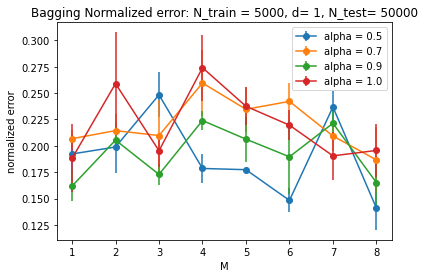

In [13]:
for i in range(len(alpha_grid)):
    plt.errorbar(np.array(M_grid),means[:,i],sigmas[:,i],marker ='o',label = f"alpha = {alpha_grid[i]}")
plt.title(f"Bagging Normalized error: N_train = {N_train}, d= {d}, N_test= {N_test}")
plt.xlabel("M")
plt.xticks(M_grid)
plt.ylabel("normalized error")
plt.legend()
plt.show()

## Store results

In [14]:
res_dict = {'N_train': N_train, 'N_test': N_test,'mgrid': M_grid, 'alpha_grid': alpha_grid, 'errors': converted_results.tolist()}

In [16]:
import json
import datetime
with open(f'bagging_w_replacement_{str(datetime.date.today())}.json', 'w') as fp:
    json.dump(res_dict, fp)